<a href="https://colab.research.google.com/github/chengyang122/Metter.js-and-MediaPipe-Interactive-game/blob/main/MMdetectionImageSegmentationMetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.4 MB/s eta 0:13:55tcmalloc: large alloc 1147494400 bytes == 0x38e1e000 @  0x7fe98c5fa615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████▌               | 1055.7 MB 1.3 MB/s eta 0:12:26tcmalloc: large alloc 1434370048 bytes == 0x7d474000 @  0x7fe98c5fa615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████           | 1336.2 MB 1.3 MB/s eta 0:09:10tcmalloc: large alloc 1792966656 bytes =

In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
import numpy as np
import json
import pandas as pd
import cv2

# Check MMDetection installation
import mmdet
print(mmdet.__version__)


# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.9.0+cu111 True
2.24.1
11.1
GCC 7.3


In [5]:
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth \
      -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

--2022-05-17 17:22:33--  https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.233
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177867103 (170M) [application/octet-stream]
Saving to: ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’

checkpoints/mask_rc 100%[===================>] 169.63M  11.2MB/s    in 18s     

2022-05-17 17:22:52 (9.40 MB/s) - ‘checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’ saved [177867103/177867103]



In [6]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

# Choose to use a config and initialize the detector
config = 'configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

load checkpoint from local path: checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth


MaskRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [7]:
# Use the detector to do inference
img = 'demo/demo.jpg'
result = inference_detector(model, img)

/content/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


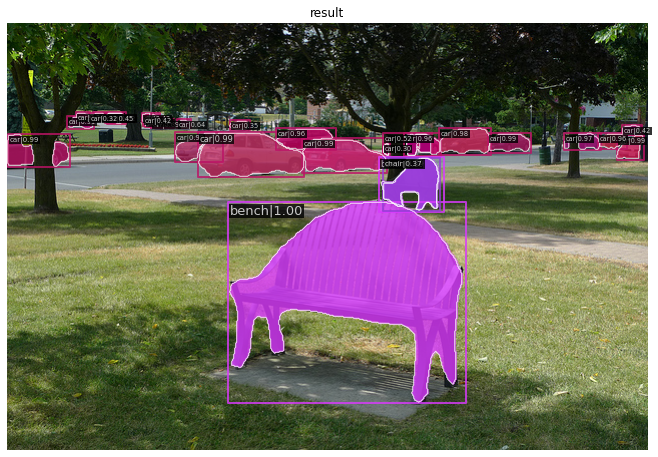

In [8]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.3)

In [9]:
import os.path as osp

def convert_balloon_to_coco(ann_file, out_file, image_prefix):
    data_infos = mmcv.load(ann_file)

    annotations = []
    images = []
    obj_count = 0
    for idx, v in enumerate(mmcv.track_iter_progress(data_infos.values())):
        filename = v['filename']
        img_path = osp.join(image_prefix, filename)
        height, width = mmcv.imread(img_path).shape[:2]

        images.append(dict(
            id=idx,
            file_name=filename,
            height=height,
            width=width))

        bboxes = []
        labels = []
        masks = []
        for _, obj in v['regions'].items():
            assert not obj['region_attributes']
            obj = obj['shape_attributes']
            px = obj['all_points_x']
            py = obj['all_points_y']
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            x_min, y_min, x_max, y_max = (
                min(px), min(py), max(px), max(py))


            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=0,
                bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                area=(x_max - x_min) * (y_max - y_min),
                segmentation=[poly],
                iscrowd=0)
            annotations.append(data_anno)
            obj_count += 1

    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=[{'id':0, 'name': 'balloon'}])
    mmcv.dump(coco_format_json, out_file)

In [42]:
def annotation(row):
    annotation = {}
    area = (row.xmax -row.xmin)*(row.ymax - row.ymin)
    annotation["bbox"] = [row.xmin, row.ymin, row.xmax -row.xmin,row.ymax-row.ymin ]
    annotation['bbox_mode'] = 1
    annotation["category_id"] = row.category_id
    annotation["segmentation"] = [[row.X1, row.Y1, row.X2, row.Y2, row.X3, row.Y3, row.X4, row.Y4]]
    
    return annotation

In [75]:
img_address_base = '/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/'
df = pd.read_excel('/content/drive/MyDrive/barcode/trainData.xlsx')
df['isBarcode'] = 1
img = cv2.imread(img_address_base + df.loc[1][0] + '.jpg')

img_address_base = '/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/'
img = cv2.imread(img_address_base + str(df.loc[10][0]) + '.jpg')

df['ymax'] = df[['Y1','Y2', 'Y3', 'Y4']].max(axis=1)
df['ymin'] = df[['Y1','Y2', 'Y3', 'Y4']].min(axis=1)
df['xmax'] = df[['X1','X2','X3','X4']].max(axis=1)
df['xmin'] = df[['X1','X2','X3','X4']].min(axis=1)
df['width'] = img.shape[1] #since all shape are the same. Can use shape of one picture 
df['height'] = img.shape[0] #since all shape are the same. Can use shape of one picture 
df['class'] = 1
df['filename'] = df['Image Filename']+ '.jpg'
df["category_id"] = 0
df
#show the shape of the output image 
def annotation(row):
    annotation = {}
    area = (row.xmax -row.xmin)*(row.ymax - row.ymin)
    annotation["bbox"] = [row.xmin, row.ymin, row.xmax -row.xmin,row.ymax-row.ymin ]
    annotation['bbox_mode'] = 1
    annotation["category_id"] = row.category_id
    annotation["segmentation"] = [[row.X1, row.Y1, row.X2, row.Y2, row.X3, row.Y3, row.X4, row.Y4]]
    
    return annotation


annotation_column = []
for row in df.itertuples():
    annotation_column.append(annotation(row))
df['annotation'] = annotation_column
g = df[['Image Filename', 'annotation']].groupby('Image Filename')['annotation'].apply(list).reset_index(name='annotations')
g.columns = ['file_name','annotations']
g['width'] = 2592
g['height'] = 1944
g['image_id'] = np.arange(len(g))
g.index=np.arange(len(g))
g.reset_index(inplace=True)
g.to_json("/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/train_dataset.json",orient="records")

images=[]
annotations=[]
id = 0
for index, row in g.iterrows():
  images.append(dict(
    id=row.image_id,
    file_name=row.file_name+'.jpg',
    height=row.height,
    width=row.width))
  
  for objects in row.annotations:
    data_anno = dict(
                      image_id=row.image_id,
                      id=id,
                      category_id=0,
                      bbox=objects.get('bbox'),
                      area=objects.get('bbox')[2]*objects.get('bbox')[3],
                      segmentation=objects.get('segmentation'),
                      iscrowd=0)
    annotations.append(data_anno)
    id = id + 1
categories=[{'id':0, 'name': 'barcode'}]

coco_format_json = dict(
    images=images,
    annotations=annotations,
    categories=[{'id':0, 'name': 'barcode'}])
mmcv.dump(coco_format_json, "/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/train_dataset.json")

In [90]:
img_address_base = '/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/'
df = pd.read_excel('/content/drive/MyDrive/barcode/testData.xlsx')
df['isBarcode'] = 1
img = cv2.imread(img_address_base + df.loc[1][0] + '.jpg')

img_address_base = '/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/'
img = cv2.imread(img_address_base + str(df.loc[10][0]) + '.jpg')

df['ymax'] = df[['Y1','Y2', 'Y3', 'Y4']].max(axis=1)
df['ymin'] = df[['Y1','Y2', 'Y3', 'Y4']].min(axis=1)
df['xmax'] = df[['X1','X2','X3','X4']].max(axis=1)
df['xmin'] = df[['X1','X2','X3','X4']].min(axis=1)
df['width'] = img.shape[1] #since all shape are the same. Can use shape of one picture 
df['height'] = img.shape[0] #since all shape are the same. Can use shape of one picture 
df['class'] = 1
df['filename'] = df['Image Filename']+ '.jpg'
df["category_id"] = 0
df
#show the shape of the output image 
def annotation(row):
    annotation = {}
    area = (row.xmax -row.xmin)*(row.ymax - row.ymin)
    annotation["bbox"] = [row.xmin, row.ymin, row.xmax -row.xmin,row.ymax-row.ymin ]
    annotation['bbox_mode'] = 1
    annotation["category_id"] = row.category_id
    annotation["segmentation"] = [[row.X1, row.Y1, row.X2, row.Y2, row.X3, row.Y3, row.X4, row.Y4]]
    
    return annotation


annotation_column = []
for row in df.itertuples():
    annotation_column.append(annotation(row))
df['annotation'] = annotation_column
g = df[['Image Filename', 'annotation']].groupby('Image Filename')['annotation'].apply(list).reset_index(name='annotations')
g.columns = ['file_name','annotations']
g['width'] = 2592
g['height'] = 1944
g['image_id'] = np.arange(len(g))
g.index=np.arange(len(g))
g.reset_index(inplace=True)
g.to_json("/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/test_dataset.json",orient="records")

images=[]
annotations=[]
id = 0
for index, row in g.iterrows():
  images.append(dict(
    id=row.image_id,
    file_name=row.file_name+'.jpg',
    height=row.height,
    width=row.width))
  
  for objects in row.annotations:
    data_anno = dict(
                      image_id=row.image_id,
                      id=id,
                      category_id=0,
                      bbox=objects.get('bbox'),
                      area=objects.get('bbox')[2]*objects.get('bbox')[3],
                      segmentation=objects.get('segmentation'),
                      iscrowd=0)
    annotations.append(data_anno)
    id = id + 1
categories=[{'id':0, 'name': 'barcode'}]

coco_format_json = dict(
    images=images,
    annotations=annotations,
    categories=[{'id':0, 'name': 'barcode'}])
mmcv.dump(coco_format_json, "/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/test_dataset.json")

In [77]:
img_address_base = '/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/'
df = pd.read_excel('/content/drive/MyDrive/barcode/validateData.xlsx')
df['isBarcode'] = 1
img = cv2.imread(img_address_base + df.loc[1][0] + '.jpg')

img_address_base = '/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/'
img = cv2.imread(img_address_base + str(df.loc[10][0]) + '.jpg')

df['ymax'] = df[['Y1','Y2', 'Y3', 'Y4']].max(axis=1)
df['ymin'] = df[['Y1','Y2', 'Y3', 'Y4']].min(axis=1)
df['xmax'] = df[['X1','X2','X3','X4']].max(axis=1)
df['xmin'] = df[['X1','X2','X3','X4']].min(axis=1)
df['width'] = img.shape[1] #since all shape are the same. Can use shape of one picture 
df['height'] = img.shape[0] #since all shape are the same. Can use shape of one picture 
df['class'] = 1
df['filename'] = df['Image Filename']+ '.jpg'
df["category_id"] = 0
df
#show the shape of the output image 
def annotation(row):
    annotation = {}
    area = (row.xmax -row.xmin)*(row.ymax - row.ymin)
    annotation["bbox"] = [row.xmin, row.ymin, row.xmax -row.xmin,row.ymax-row.ymin ]
    annotation['bbox_mode'] = 1
    annotation["category_id"] = row.category_id
    annotation["segmentation"] = [[row.X1, row.Y1, row.X2, row.Y2, row.X3, row.Y3, row.X4, row.Y4]]
    
    return annotation


annotation_column = []
for row in df.itertuples():
    annotation_column.append(annotation(row))
df['annotation'] = annotation_column
g = df[['Image Filename', 'annotation']].groupby('Image Filename')['annotation'].apply(list).reset_index(name='annotations')
g.columns = ['file_name','annotations']
g['width'] = 2592
g['height'] = 1944
g['image_id'] = np.arange(len(g))
g.index=np.arange(len(g))
g.reset_index(inplace=True)
g.to_json("/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/validate_dataset.json",orient="records")

images=[]
annotations=[]
id = 0
for index, row in g.iterrows():
  images.append(dict(
    id=row.image_id,
    file_name=row.file_name+'.jpg',
    height=row.height,
    width=row.width))
  
  for objects in row.annotations:
    data_anno = dict(
                      image_id=row.image_id,
                      id=id,
                      category_id=0,
                      bbox=objects.get('bbox'),
                      area=objects.get('bbox')[2]*objects.get('bbox')[3],
                      segmentation=objects.get('segmentation'),
                      iscrowd=0)
    annotations.append(data_anno)
    id = id + 1
categories=[{'id':0, 'name': 'barcode'}]

coco_format_json = dict(
    images=images,
    annotations=annotations,
    categories=[{'id':0, 'name': 'barcode'}])
mmcv.dump(coco_format_json, "/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/validate_dataset.json")

In [93]:
from mmcv import Config
cfg = Config.fromfile('./configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_1x_coco.py')

In [94]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'COCODataset'

cfg.data.test.ann_file = '/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/test_dataset.json'
cfg.data.test.img_prefix = '/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/'
cfg.data.test.classes = ('barcode',)

cfg.data.train.ann_file = '/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/train_dataset.json'
cfg.data.train.img_prefix = '/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/'
cfg.data.train.classes = ('barcode',)


cfg.data.val.ann_file = '/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/validate_dataset.json'
cfg.data.val.img_prefix = '/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/'
cfg.data.val.classes = ('barcode',)

# modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head.num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# We can still the pre-trained Mask RCNN model to obtain a higher performance
cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = [0]

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

cfg.device = 'cuda'
# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='Cross

In [95]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


2022-05-17 20:29:03,140 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-05-17 20:29:03,149 - mmdet - INFO - load checkpoint from local path: checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
2022-05-17 20:29:03,289 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoin

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/content/mmdetection/mmdet/core/mask/structures.py:1071: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bitmap_mask = maskUtils.decode(rle).astype(np.bool)
2022-05-17 20:29:08,529 - mmdet - INFO - Epoch [1][10/59]	lr: 2.500e-03, eta: 0:06:00, time: 0.516, data_time: 0.269, memory: 3982, loss_rpn_cls: 0.1659, loss_rpn_bbox: 0.0566, loss_cls: 0.4046, acc: 82.7344, loss_bbox: 0.5427, loss_mask: 0.5366, loss: 1.7064
2022-05-17 20:29:10,845 - mmdet - INFO - Epoch [1][20/59]	lr: 2.500e-03, eta: 0:04:17, time: 0.232, data_time: 0.019, memory: 3982, loss_rpn_cls: 0.0347, loss_rpn_bbox: 0.0316, loss_cls: 0.2094, acc: 91.7188, loss_bbox: 0.4409, loss_mask: 0.2250, loss: 0.9416


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 2.9 task/s, elapsed: 1s, ETA:     0s

2022-05-17 20:32:32,748 - mmdet - INFO - Evaluating bbox...
/usr/local/lib/python3.7/dist-packages/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2022-05-17 20:32:32,781 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.845
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.935
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.935
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/content/mmdetection/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2022-05-17 20:32:32,827 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.684
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.962
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ]

DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).


In [ ]:
cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

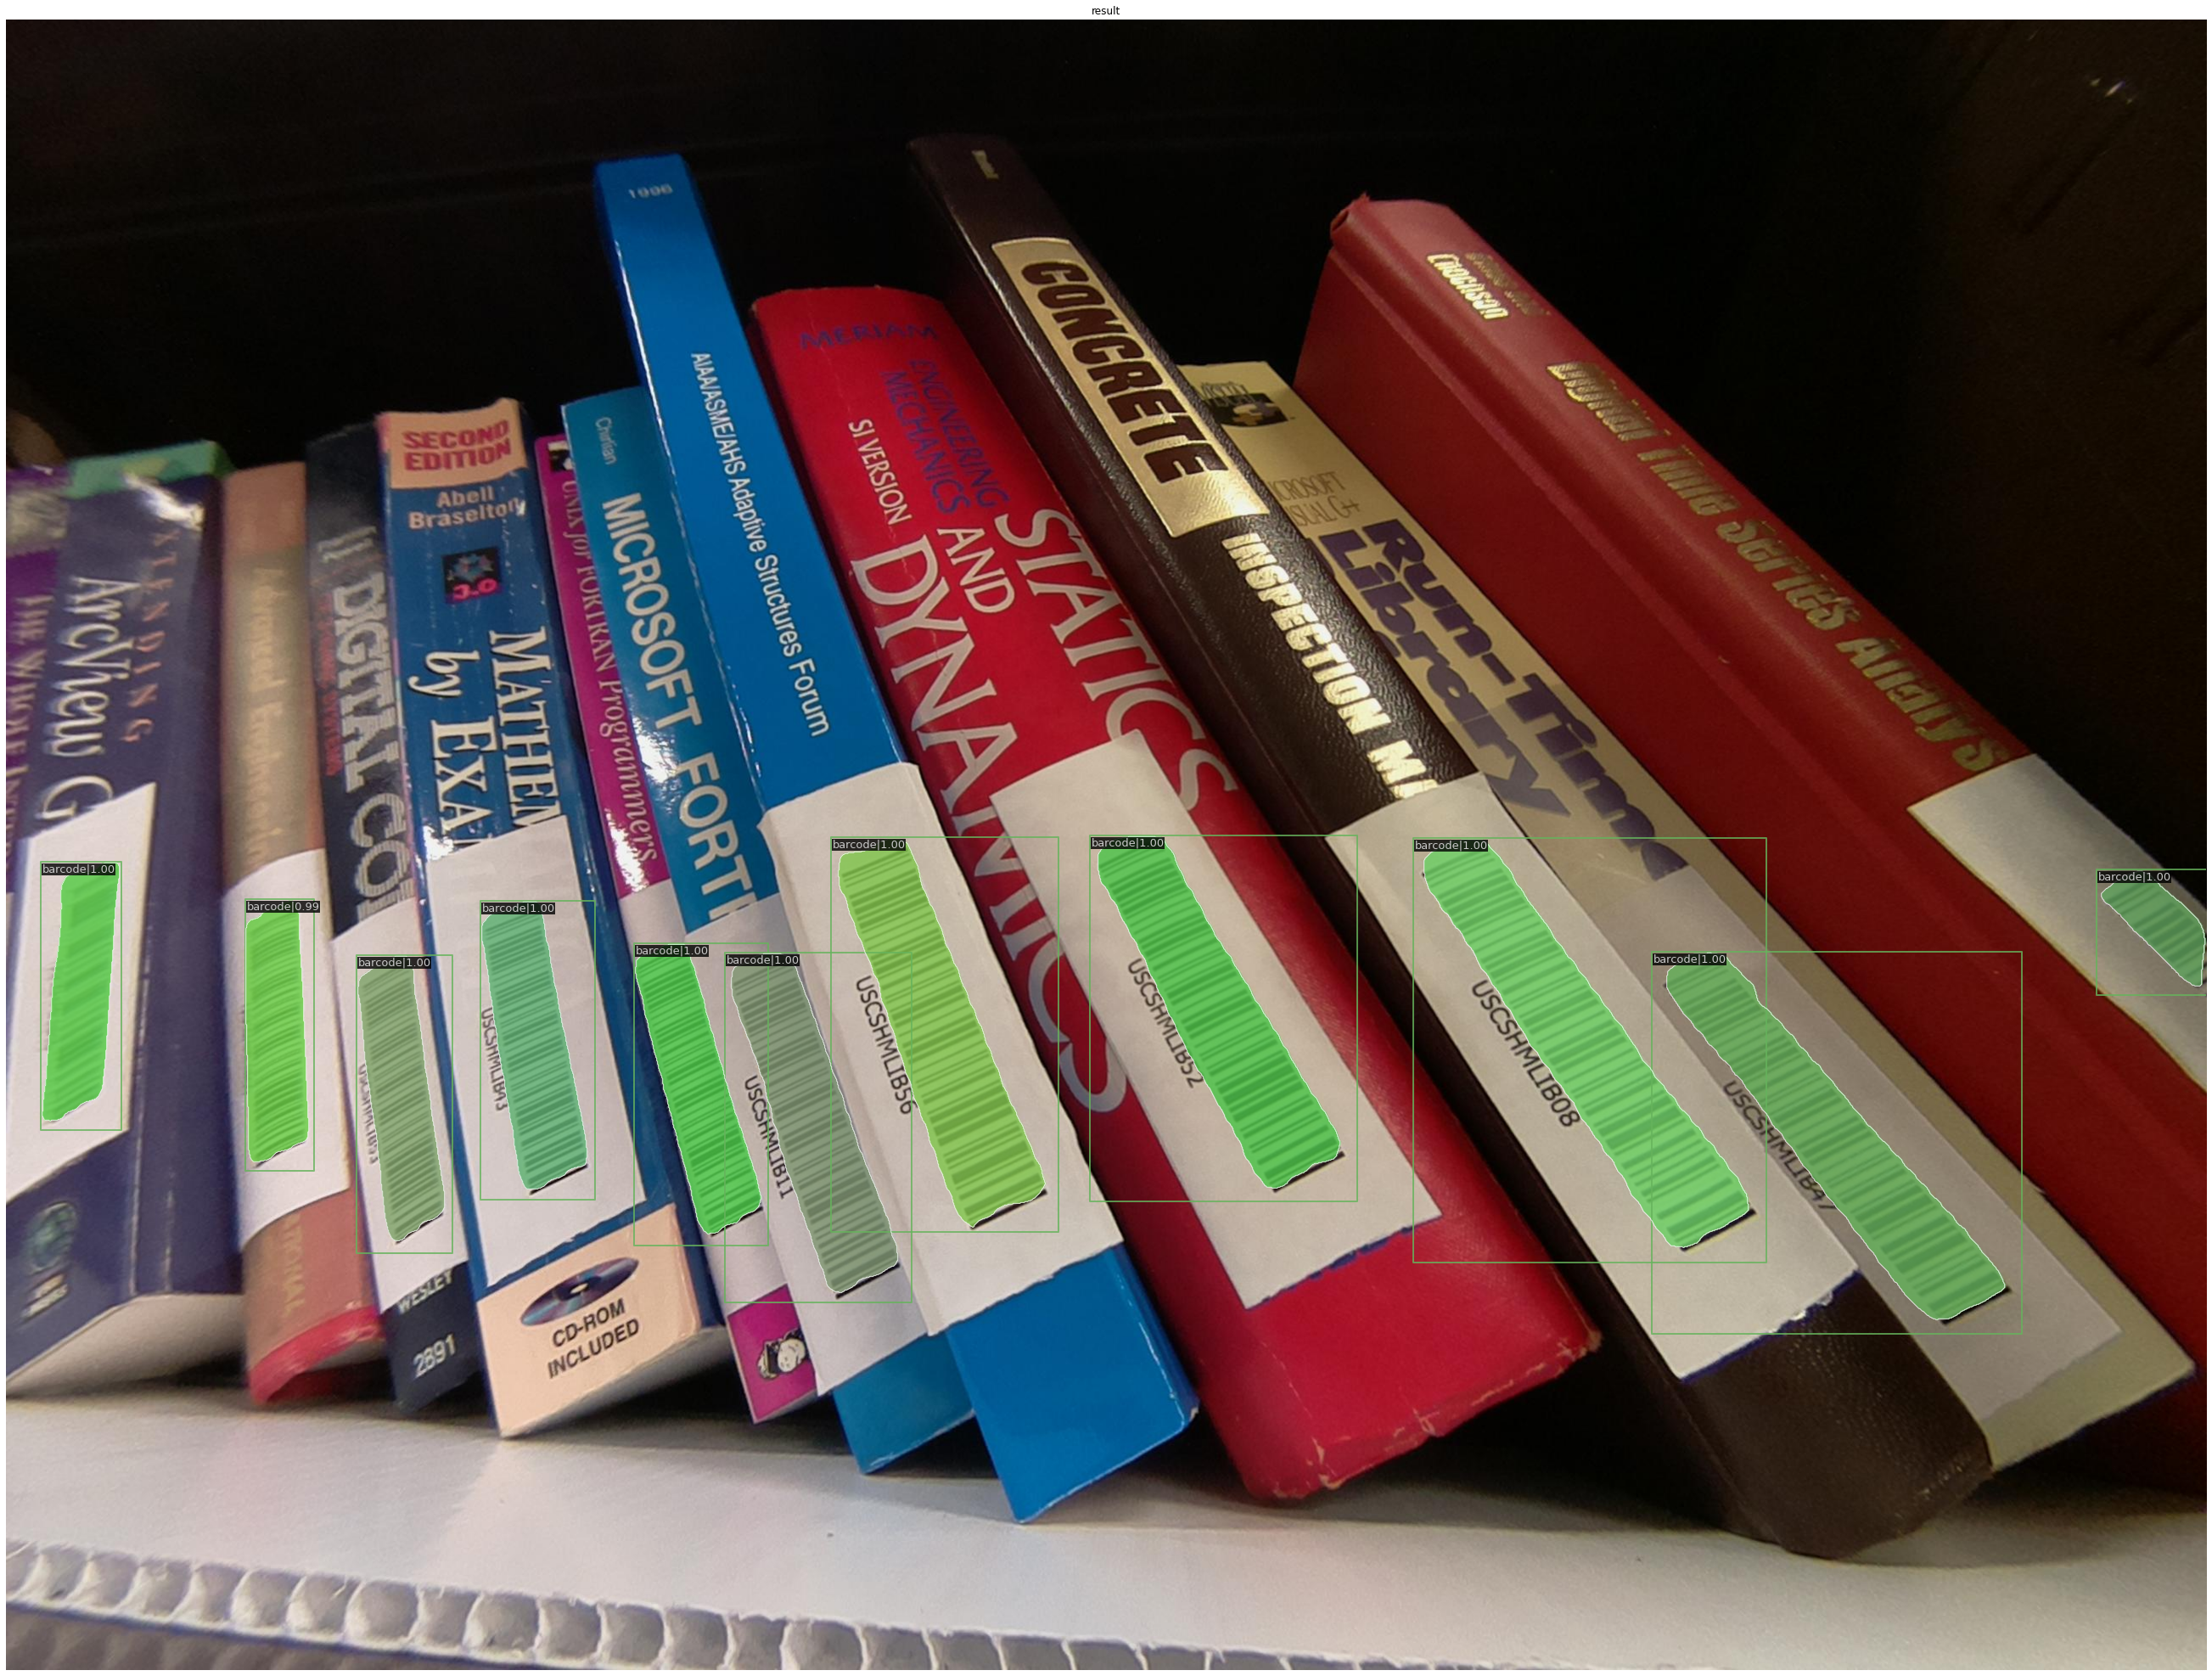

In [99]:
#img = mmcv.imread('/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/20170614-19_15_57-raspberrypi-camC_undistored.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [89]:
cfg = Config.fromfile('/content/mmdetection/configs/mask_rcnn/mask_rcnn_r101_caffe_fpn_1x_coco.py')

# Modify dataset type and path
cfg.dataset_type = 'COCODataset'

cfg.data.test.ann_file = '/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/test_dataset.json'
cfg.data.test.img_prefix = '/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/'
cfg.data.test.classes = ('barcode',)

cfg.data.train.ann_file = '/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/train_dataset.json'
cfg.data.train.img_prefix = '/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/'
cfg.data.train.classes = ('barcode',)


cfg.data.val.ann_file = '/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/validate_dataset.json'
cfg.data.val.img_prefix = '/content/drive/MyDrive/barcode/Ananya.zip (Unzipped Files)/'
cfg.data.val.classes = ('barcode',)

# modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head.num_classes = 1
cfg.model.roi_head.mask_head.num_classes = 1

# We can still the pre-trained Mask RCNN model to obtain a higher performance
cfg.load_from = '/content/drive/MyDrive/barcode/checkpoint/mask_rcnn_swin_small_patch4_window7.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = [0]

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

cfg.device = 'cuda'
# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

FileNotFoundError: ignored

In [88]:
# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


TypeError: ignored